# Motivation

The datasets used in this project we're originally provided as part of a skills assessment test to the Consumer Finance Protection Bureau.  The test was to test for:

    1. Subject matter expertise
    2. Analitical thinking
    3. Written communication

# Question

### Can I predict if a comsumer will dispute a response based on their zipcode's percentages of income brackets. 

This Question was developed based on applying categorization to consumer complaints data, while making use of the relevant income data sources from the American Community Survey.

# Hypothesis

I beleive that there will be more disputes for associated with zipcodes that have higher percentages of high income brackets.  This is because they have a greater amount of assets to lose, but also because they have more resources at their disposal.

In [218]:
#Import Libraries

#Data
import pandas as pd
import numpy as np

#Visual
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Learning
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression


# Import Consumer Complaints Data

Source: (http://www.consumerfinance.gov/complaintdatabase/)

The Complaints data can be access by downloading a file in your desired format, or you can utilize their API's.  I have chosen to download the CSV file to get all the fields available in one file.


In [177]:
Complaints = pd.read_csv('Consumer_Complaints.csv', low_memory =False)
Complaints.columns = [c.replace(' ', '_') for c in Complaints.columns]
Complaints.head()

,Date_received,Product,Sub-product,Issue,Sub-issue,Consumer_complaint_narrative,Company_public_response,Company,State,ZIP_code,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response?,Consumer_disputed?,Complaint_ID
0,07/15/2015,Bank account or service,Checking account,Problems caused by my funds being low,NaN,NaN,NaN,Santander Bank US,NJ,088XX,Web,07/15/2015,In progress,Yes,NaN,1470116
1,07/15/2015,Debt collection,"Other (phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,Transworld Systems Inc.,NY,11226,Web,07/15/2015,In progress,Yes,NaN,1469995
2,07/15/2015,Debt collection,Payday loan,False statements or representation,Impersonated an attorney or official,NaN,NaN,"Green Tree Servicing, LLC",PA,174XX,Web,07/15/2015,Closed with explanation,Yes,NaN,1469985
3,07/15/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Flagstar Bank,TN,381XX,Web,07/15/2015,In progress,Yes,NaN,1470653
4,07/15/2015,Debt collection,Mortgage,Communication tactics,Frequent or repeated calls,NaN,NaN,Ocwen,NC,274XX,Web,07/15/2015,Closed with explanation,Yes,NaN,1469337


In [178]:
Complaints.shape

(419985, 16)

In [180]:
Complaints.dtypes

Date_received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer_complaint_narrative    object
Company_public_response         object
Company                         object
State                           object
ZIP_code                        object
Submitted_via                   object
Date_sent_to_company            object
Company_response_to_consumer    object
Timely_response?                object
Consumer_disputed?              object
Complaint_ID                     int64
dtype: object

In [181]:
#Remove "In progress" Complaints because they should never have disputes
Complaints = Complaints[Complaints.Company_response_to_consumer != 'In progress']

#Minimize to only the necessary columns
Complaints = Complaints[['Complaint_ID', 'ZIP_code', 'Consumer_disputed?']]

#Fill in NaN's with No.  Will be assumed that there is no dispute
Complaints['Consumer_disputed?'].fillna('No', inplace=True)

Complaints.head()

,Complaint_ID,ZIP_code,Consumer_disputed?
2,1469985,174XX,No
4,1469337,274XX,No
6,1468767,442XX,No
7,1469091,032XX,Yes
8,1469096,278XX,Yes


In [182]:
Complaints['Consumer_disputed?'].value_counts()

No     330814
Yes     85928
dtype: int64

In [183]:
#Prepare Complaints for joining on ZIP_code
Complaints = Complaints.dropna(subset = ['ZIP_code'])
Complaints = Complaints[Complaints.ZIP_code.str.contains("XX") ==False]
Complaints[['ZIP_code']] = Complaints [['ZIP_code']].astype(int)
Complaints.shape

(391798, 3)

# Import Geography Data

### Geography information for the 5-year ACS survey file from census.gov

CSV data file: (http://www2.census.gov/acs2013_5yr/summaryfile/2009-2013_ACSSF_By_State_By_Sequence_Table_Subset/UnitedStates/All_Geographies_Not_Tracts_Block_Groups/g20135us.csv)

PDF for header fields: (http://www2.census.gov/acs2013_5yr/summaryfile/ACS_2013_SF_Tech_Doc.pdf)

Within the PDF, the field titles are provided on Page 10.  I have manually typed the titles to be attached onto the data import.  Few of the fields within the file are actually important and it is mainly used as a bridge between the Complaints Data and the Income Data that will be imported after this. 

In [184]:
#Import Geography Data
geo_cols = ['FILEID', 'STUSAB', 'SUMLEVEL', 'COMPONENT', 'LOGRECNO', 'US', 'REGION', 'DIVISION', 'STATECE', 'STATE', 'COUNTY', 'COUSUB', 'PLACE', 'TRACT', 'BLKGRP', 'CONCIT', 'AIANHH', 'AIANHHFP', 'AIHHTLI', 'AITSCE', 'AITS', 'ANRC', 'CBSA', 'CSA', 'METDIV', 'MACC', 'MEMI', 'NECTA', 'CNECTA', 'NECTADIV', 'UA', 'BLANK', 'CDCURR', 'SLDU', 'SLDL', 'BLANK', 'BLANK', 'ZCTA5', 'SUBMCD', 'SDELM', 'SDSEC', 'SDUNI', 'UR', 'PCI', 'BLANK', 'BLANK', 'PUMA5', 'BLANK', 'GEOID', 'NAME', 'BTTR', 'BTBG', 'BLANK']

Geography = pd.read_csv('g20135us.csv', low_memory = False, names=geo_cols, index_col='LOGRECNO')

Geography.head()

,FILEID,STUSAB,SUMLEVEL,COMPONENT,US,REGION,DIVISION,STATECE,STATE,COUNTY,...,PCI,BLANK,BLANK,PUMA5,BLANK,GEOID,NAME,BTTR,BTBG,BLANK
LOGRECNO,,,,,,,,,,,,,,,,,,,,,
1,ACSSF,US,10,00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01000US,United States,NaN,NaN,NaN
2,ACSSF,US,10,01,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01001US,United States -- Urban,NaN,NaN,NaN
3,ACSSF,US,10,43,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01043US,United States -- Rural,NaN,NaN,NaN
4,ACSSF,US,10,89,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01089US,United States -- American Indian Reservation a...,NaN,NaN,NaN
5,ACSSF,US,10,90,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01090US,United States -- American Indian Reservation a...,NaN,NaN,NaN


In [185]:
Geography = Geography[['ZCTA5']]

Geography.shape

(43600, 1)

In [186]:
Geography.isnull().sum()

ZCTA5    10611
dtype: int64

In [187]:
#Prepare Geography Data for joins
Geography = Geography.dropna(subset = ['ZCTA5'])
Geography.ZCTA5 = Geography.ZCTA5.astype(int)

# Import Income Data

### Income data from the 5-year ACS survey file from census.gov

Data File: (http://www2.census.gov/acs2013_5yr/summaryfile/2009-2013_ACSSF_By_State_By_Sequence_Table_Subset/UnitedStates/All_Geographies_Not_Tracts_Block_Groups/20135us0015000.zip)

Header: (http://www2.census.gov/programs-surveys/acs/summary_file/2013/data/2013_5yr_Summary_FileTemplates.zip)

There are two csv files within the Data file zip. The file starting with E is for Estimates, M file is for Margin.  For this project, we will be using the estimates file. 

The headers for many of the ACS files are located in the File Templates zip.  The one associated with Income data is 'Seq15.xls'. 

In [188]:
header = pd.ExcelFile('Seq15.xls').parse('E', header= None)
header = header.values[0].tolist()

Income = pd.read_csv('e20135us0015000.txt', low_memory=False, names=header, index_col='LOGRECNO')
Income.head()

,FILEID,FILETYPE,STUSAB,CHARITER,SEQUENCE,B06010_001,B06010_002,B06010_003,B06010_004,B06010_005,...,B06012PR_011,B06012PR_012,B06012PR_013,B06012PR_014,B06012PR_015,B06012PR_016,B06012PR_017,B06012PR_018,B06012PR_019,B06012PR_020
LOGRECNO,,,,,,,,,,,,,,,,,,,,,
1,ACSSF,201300000,us,0,15,250402813,34802040,215600773,44355459,22540898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACSSF,201300000,us,0,15,201744568,28436760,173307808,35521436,17854654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACSSF,201300000,us,0,15,48658245,6365280,42292965,8834023,4686244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACSSF,201300000,us,0,15,773005,153069,619936,176394,72674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ACSSF,201300000,us,0,15,999,230,769,230,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
Income.shape

(43600, 165)

# Interesting Income Data Fields

## These can be used for further reference if any additional analysis is conducted

* B06010_001 : Population 15 years and over in the United States

### Income Brackets
* B06010_002 : No Income
* B06010_003 : With Income
* B06010_004 : 1-9999
* B06010_005 : 10000-14999
* B06010_006 : 15000-24999
* B06010_007 : 25000-34999
* B06010_008 : 35000-49999
* B06010_009 : 50000-64999
* B06010_010 : 65000-74999
* B06010_011 : 75000-Or More

### Other Fields
* B06010_012 : Born in State of Residence
* B06010_023 : Born in other state in the United States
* B06010_034 : Native; born outside the United States
* B06010_045 : Foreign born
 
### Medians Incomes
* B06011_001 : Population 15 years and over in the United States with income
* B06011_002 : Born in state of residence
* B06011_003 : Born in other state of the United States
* B06011_004 : Native; born outside the United States
* B06011_005 : Foreign born

In [190]:
Income.columns

Index([      u'FILEID',     u'FILETYPE',       u'STUSAB',     u'CHARITER',
           u'SEQUENCE',   u'B06010_001',   u'B06010_002',   u'B06010_003',
         u'B06010_004',   u'B06010_005', 
       ...
       u'B06012PR_011', u'B06012PR_012', u'B06012PR_013', u'B06012PR_014',
       u'B06012PR_015', u'B06012PR_016', u'B06012PR_017', u'B06012PR_018',
       u'B06012PR_019', u'B06012PR_020'],
      dtype='object', length=165)

In [191]:
#Chosing only the columns that we want
Income = Income[['B06010_001', 'B06010_002', 'B06010_003', 'B06010_004', 'B06010_005', 'B06010_006', 'B06010_007', 'B06010_008', 'B06010_009', 'B06010_010', 'B06010_011', 'B06011_001']]

In [192]:
#Renaming the columns to be more readable
Income = Income.rename(columns = {'B06010_001':'Population', 'B06010_002':'IncNone', 'B06010_003':'WithInc', 'B06010_004':'Inc1_10', 'B06010_005':'Inc10_15', 'B06010_006':'Inc15_25', 'B06010_007' : 'Inc25_35', 'B06010_008' : 'Inc35_50', 'B06010_009' : 'Inc50_65', 'B06010_010' : 'Inc65_75', 'B06010_011' : 'Inc75_Up', 'B06011_001': 'IncMedian'})
zip(Income.columns)

[('Population',),
 ('IncNone',),
 ('WithInc',),
 ('Inc1_10',),
 ('Inc10_15',),
 ('Inc15_25',),
 ('Inc25_35',),
 ('Inc35_50',),
 ('Inc50_65',),
 ('Inc65_75',),
 ('Inc75_Up',),
 ('IncMedian',)]

In [193]:
Income.dtypes

Population    float64
IncNone       float64
WithInc       float64
Inc1_10       float64
Inc10_15      float64
Inc15_25      float64
Inc25_35      float64
Inc35_50      float64
Inc50_65      float64
Inc65_75      float64
Inc75_Up      float64
IncMedian      object
dtype: object

In [194]:
#Why is IncMedian not a float?
zip(Income.IncMedian.order().unique())

[('.',),
 ('10000',),
 ('10022',),
 ('10034',),
 ('10050',),
 ('10054',),
 ('10056',),
 ('100625',),
 ('10063',),
 ('10066',),
 ('10073',),
 ('10075',),
 ('10078',),
 ('10083',),
 ('10089',),
 ('10109',),
 ('10110',),
 ('10127',),
 ('10167',),
 ('10170',),
 ('10179',),
 ('10192',),
 ('10227',),
 ('10229',),
 ('10232',),
 ('10250',),
 ('10258',),
 ('10260',),
 ('10268',),
 ('10272',),
 ('102768',),
 ('10277',),
 ('10291',),
 ('10292',),
 ('10313',),
 ('10317',),
 ('10341',),
 ('10344',),
 ('10357',),
 ('10363',),
 ('10368',),
 ('10375',),
 ('10381',),
 ('10384',),
 ('10391',),
 ('10395',),
 ('10413',),
 ('10417',),
 ('10431',),
 ('10432',),
 ('10433',),
 ('10436',),
 ('10451',),
 ('10455',),
 ('10458',),
 ('10461',),
 ('10465',),
 ('10469',),
 ('10473',),
 ('10481',),
 ('10488',),
 ('10500',),
 ('10507',),
 ('10515',),
 ('10521',),
 ('10531',),
 ('10536',),
 ('10543',),
 ('10546',),
 ('105556',),
 ('10556',),
 ('10558',),
 ('10563',),
 ('10568',),
 ('10574',),
 ('10575',),
 ('10583',),


### How will we address these non-numeric values?
'.' is not a NaN, but will have to be replaced. For now we will force them to be NaN's and calulate a reasonable value if they persist after the joins.

In [195]:
Income.IncMedian.replace('.', np.nan, inplace=True)
Income.IncMedian = Income.IncMedian.astype('float')
Income.dtypes

Population    float64
IncNone       float64
WithInc       float64
Inc1_10       float64
Inc10_15      float64
Inc15_25      float64
Inc25_35      float64
Inc35_50      float64
Inc50_65      float64
Inc65_75      float64
Inc75_Up      float64
IncMedian     float64
dtype: object

# Merge ACS Tables & Minimize Columns

I will be joining the ACS files first because the both share the LogRecNo' field, which should match perfectly since it is all Census data.

In [196]:
ACS = Geography.join(Income, how='inner')
ACS.head()

,ZCTA5,Population,IncNone,WithInc,Inc1_10,Inc10_15,Inc15_25,Inc25_35,Inc35_50,Inc50_65,Inc65_75,Inc75_Up,IncMedian
LOGRECNO,,,,,,,,,,,,,
10612,1001,14441,1256,13185,2266,1534,1949,1889,1882,1582,582,1501,29978
10613,1002,26281,3013,23268,10403,1705,2561,1675,1783,1374,809,2958,13128
10614,1003,10986,1451,9535,9039,216,193,41,34,0,0,12,2907
10615,1005,4338,536,3802,572,230,566,457,544,749,260,424,35984
10616,1007,11839,950,10889,1888,990,1583,1324,1485,1213,619,1787,32462


In [197]:
ACS.shape

(32989, 13)

In [198]:
ACS.isnull().sum()

ZCTA5           0
Population      0
IncNone         0
WithInc         0
Inc1_10         0
Inc10_15        0
Inc15_25        0
Inc25_35        0
Inc35_50        0
Inc50_65        0
Inc65_75        0
Inc75_Up        0
IncMedian     612
dtype: int64

# Combined All Dataframes

We will now join the Complaints data to the ACS file so that we have a workable dataframe that includes all the necessary data.

In [199]:
Voltron = pd.merge(Complaints, ACS, left_on = 'ZIP_code', right_on = 'ZCTA5', how='inner')
Voltron.set_index('Complaint_ID', inplace=True)
Voltron.sort_index(inplace=True)
Voltron.head()

,ZIP_code,Consumer_disputed?,ZCTA5,Population,IncNone,WithInc,Inc1_10,Inc10_15,Inc15_25,Inc25_35,Inc35_50,Inc50_65,Inc65_75,Inc75_Up,IncMedian
Complaint_ID,,,,,,,,,,,,,,,
1,85053,No,85053,23365,3385,19980,3476,1923,3701,3333,3674,1682,631,1560,27372
5,93551,No,93551,39640,8720,30920,5537,3098,3396,3161,3767,3212,1574,7175,35980
7,92567,No,92567,6895,1531,5364,1098,802,1218,663,633,399,89,462,20925
16,48412,Yes,48412,4775,621,4154,918,433,722,538,655,336,177,375,25060
20,19464,No,19464,36225,3109,33116,5764,3356,5428,4339,5557,3330,1420,3922,29497


In [200]:
Voltron.shape

(379301, 15)

In [201]:
Voltron.isnull().sum()

ZIP_code                0
Consumer_disputed?      0
ZCTA5                   0
Population              0
IncNone                 0
WithInc                 0
Inc1_10                 0
Inc10_15                0
Inc15_25                0
Inc25_35                0
Inc35_50                0
Inc50_65                0
Inc65_75                0
Inc75_Up                0
IncMedian             254
dtype: int64

# Transform Data & Conduct Further Cleaning
The Income Brackets will be converted to percentages of population

In [202]:
Voltron['IncNoneP'] = Voltron.IncNone/Voltron.Population
Voltron['Inc1_25P'] = (Voltron.Inc1_10+Voltron.Inc10_15+Voltron.Inc15_25)/Voltron.Population
Voltron['Inc25_50P'] = (Voltron.Inc25_35+Voltron.Inc35_50)/Voltron.Population
Voltron['Inc50_75P'] = (Voltron.Inc50_65+Voltron.Inc65_75)/Voltron.Population
Voltron['Inc75_UpP'] = Voltron.Inc75_Up/Voltron.Population
Voltron['Disputed_Bit'] = Voltron['Consumer_disputed?'].map({'Yes':1, 'No':0})
Voltron.head()

,ZIP_code,Consumer_disputed?,ZCTA5,Population,IncNone,WithInc,Inc1_10,Inc10_15,Inc15_25,Inc25_35,...,Inc50_65,Inc65_75,Inc75_Up,IncMedian,IncNoneP,Inc1_25P,Inc25_50P,Inc50_75P,Inc75_UpP,Disputed_Bit
Complaint_ID,,,,,,,,,,,,,,,,,,,,,
1,85053,No,85053,23365,3385,19980,3476,1923,3701,3333,...,1682,631,1560,27372,0.144875,0.389471,0.299893,0.098994,0.066767,0
5,93551,No,93551,39640,8720,30920,5537,3098,3396,3161,...,3212,1574,7175,35980,0.219980,0.303507,0.174773,0.120737,0.181004,0
7,92567,No,92567,6895,1531,5364,1098,802,1218,663,...,399,89,462,20925,0.222045,0.452212,0.187962,0.070776,0.067005,0
16,48412,Yes,48412,4775,621,4154,918,433,722,538,...,336,177,375,25060,0.130052,0.434136,0.249843,0.107435,0.078534,1
20,19464,No,19464,36225,3109,33116,5764,3356,5428,4339,...,3330,1420,3922,29497,0.085825,0.401601,0.273182,0.131125,0.108268,0


In [203]:
Voltron.isnull().sum()

ZIP_code                0
Consumer_disputed?      0
ZCTA5                   0
Population              0
IncNone                 0
WithInc                 0
Inc1_10                 0
Inc10_15                0
Inc15_25                0
Inc25_35                0
Inc35_50                0
Inc50_65                0
Inc65_75                0
Inc75_Up                0
IncMedian             254
IncNoneP              148
Inc1_25P              148
Inc25_50P             148
Inc50_75P             148
Inc75_UpP             148
Disputed_Bit            0
dtype: int64

In [204]:
#IncMedian NaNs still persist, but also the calculated percentages produced NaNs due by dividing by 0's from the Population field.
Voltron[Voltron.IncMedian.isnull() == True]

,ZIP_code,Consumer_disputed?,ZCTA5,Population,IncNone,WithInc,Inc1_10,Inc10_15,Inc15_25,Inc25_35,...,Inc50_65,Inc65_75,Inc75_Up,IncMedian,IncNoneP,Inc1_25P,Inc25_50P,Inc50_75P,Inc75_UpP,Disputed_Bit
Complaint_ID,,,,,,,,,,,,,,,,,,,,,
11573,57439,Yes,57439,60,0,60,0,0,0,60,...,0,0,0,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,1
14435,79105,No,79105,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
16788,78335,No,78335,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
18751,94972,No,94972,38,0,38,0,0,0,0,...,19,0,0,NaN,0.000000,0.000000,0.500000,0.500000,0.000000,0
22230,21717,No,21717,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
23661,20510,No,20510,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
24435,19710,No,19710,18,9,9,0,0,9,0,...,0,0,0,NaN,0.500000,0.500000,0.000000,0.000000,0.000000,0
28700,21705,No,21705,3,2,1,1,0,0,0,...,0,0,0,NaN,0.666667,0.333333,0.000000,0.000000,0.000000,0
35225,27340,No,27340,33,0,33,0,0,0,0,...,33,0,0,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,0


In [205]:
#Dropping based on any of the calculated fields should remove any records where there is a 0 population
Voltron = Voltron.dropna(subset = ['IncNoneP'])

#I will fill in the IncMedian values with the following equation 12500*Inc1_25P + 37500*Inc25_50P + 62500*Inc50_75P + 87500*Inc75_UpP
Voltron.loc[Voltron.IncMedian.isnull() == True, 'IncMedian'] = ((12500*Voltron.Inc1_25P) + (37500*Voltron.Inc25_50P) + (62500*Voltron.Inc50_75P) + (87500*Voltron.Inc75_UpP))

In [206]:
Voltron.isnull().sum()

ZIP_code              0
Consumer_disputed?    0
ZCTA5                 0
Population            0
IncNone               0
WithInc               0
Inc1_10               0
Inc10_15              0
Inc15_25              0
Inc25_35              0
Inc35_50              0
Inc50_65              0
Inc65_75              0
Inc75_Up              0
IncMedian             0
IncNoneP              0
Inc1_25P              0
Inc25_50P             0
Inc50_75P             0
Inc75_UpP             0
Disputed_Bit          0
dtype: int64

# Visualization & Exploration

In [157]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 10

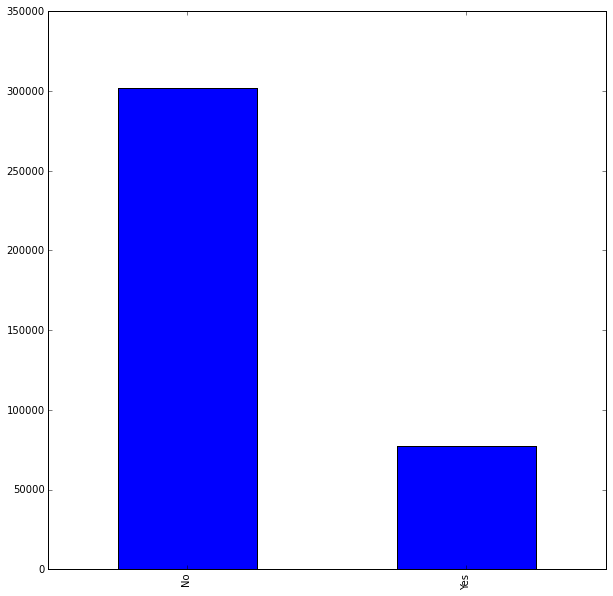

In [158]:
Voltron['Consumer_disputed?'].value_counts().plot(kind='bar')


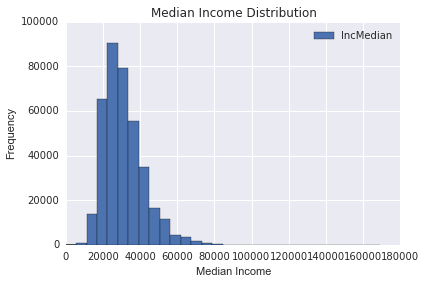

In [230]:
Voltron[['IncMedian']].plot(kind='hist', bins=30, title='Median Income Distribution')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

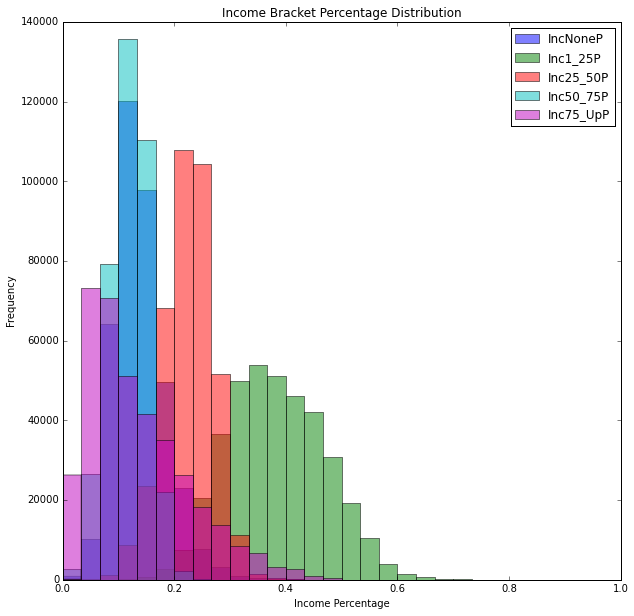

In [154]:
Voltron[['IncNoneP','Inc1_25P','Inc25_50P','Inc50_75P','Inc75_UpP']].plot(kind='hist', bins=30, title='Income Bracket Percentage Distribution', alpha=0.5)
plt.xlabel('Income Percentage')
plt.ylabel('Frequency')

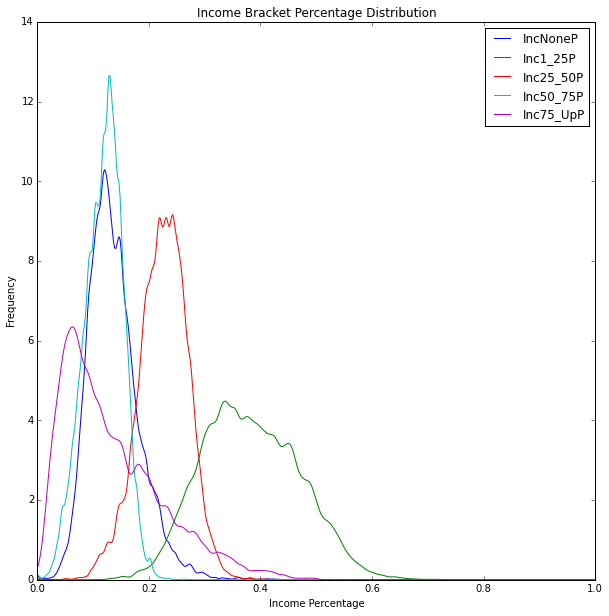

In [155]:
#This takes long to generate, but offers a better view of all the distributions
Voltron[['IncNoneP','Inc1_25P','Inc25_50P','Inc50_75P','Inc75_UpP']].plot(kind='density', title='Income Bracket Percentage Distribution', xlim=(0, 1))
plt.xlabel('Income Percentage')
plt.ylabel('Frequency')

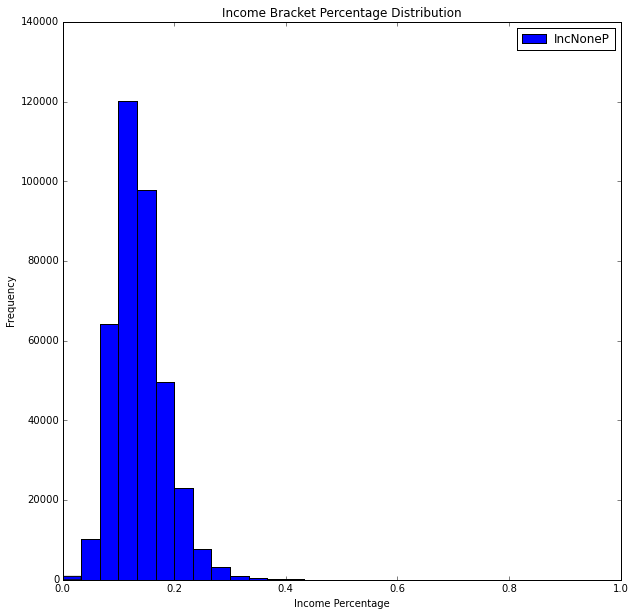

In [160]:
Voltron[['IncNoneP']].plot(kind='hist', bins=30, title='Income Bracket Percentage Distribution', ylim=(0, 140000))
plt.xlabel('Income Percentage')
plt.ylabel('Frequency')

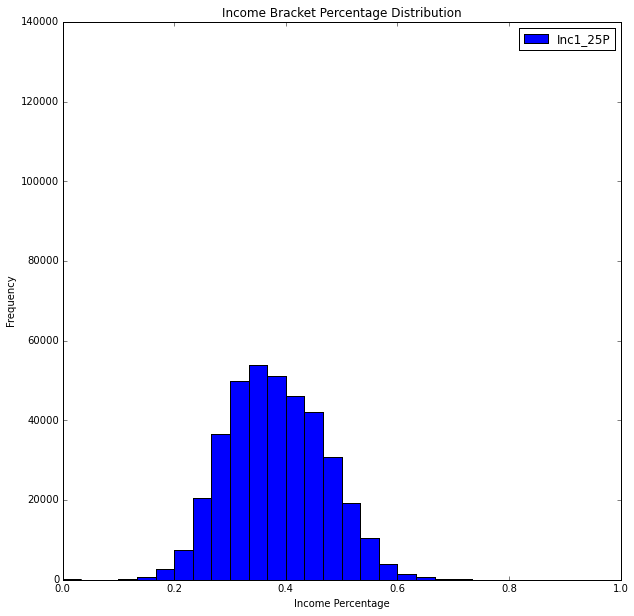

In [161]:
Voltron[['Inc1_25P']].plot(kind='hist', bins=30, title='Income Bracket Percentage Distribution', ylim=(0, 140000))
plt.xlabel('Income Percentage')
plt.ylabel('Frequency')

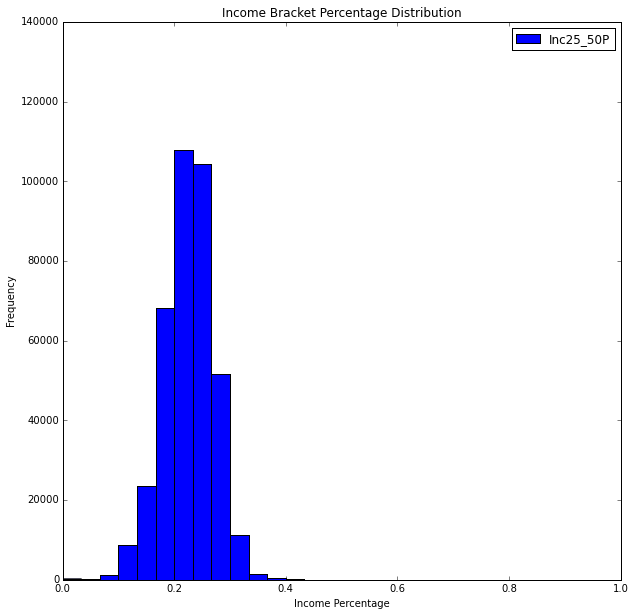

In [162]:
Voltron[['Inc25_50P']].plot(kind='hist', bins=30, title='Income Bracket Percentage Distribution', ylim=(0, 140000))
plt.xlabel('Income Percentage')
plt.ylabel('Frequency')

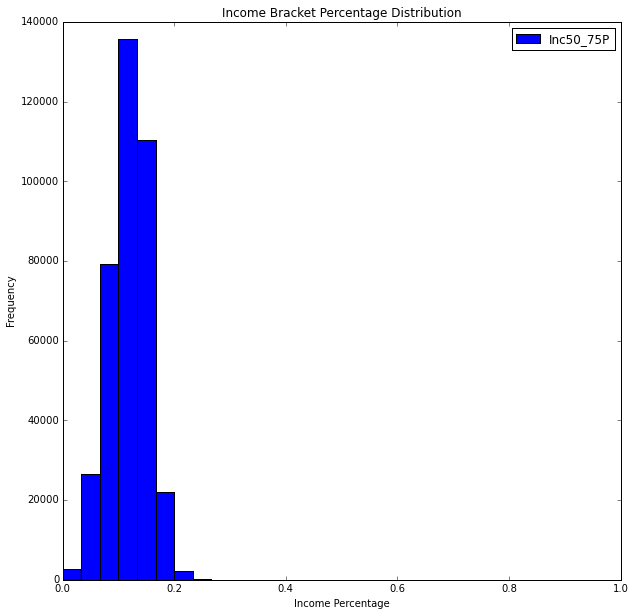

In [163]:
Voltron[['Inc50_75P']].plot(kind='hist', bins=30, title='Income Bracket Percentage Distribution', ylim=(0, 140000))
plt.xlabel('Income Percentage')
plt.ylabel('Frequency')

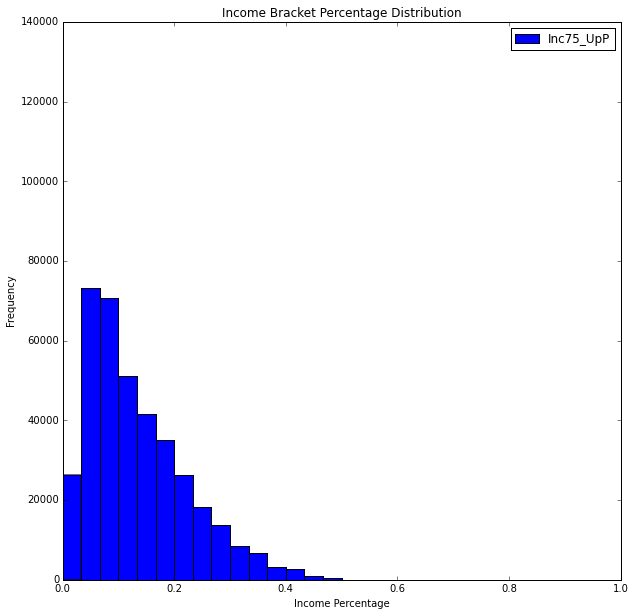

In [164]:
Voltron[['Inc75_UpP']].plot(kind='hist', bins=30, title='Income Bracket Percentage Distribution', ylim=(0, 140000))
plt.xlabel('Income Percentage')
plt.ylabel('Frequency')

### Historgram Analaysis
From the histogram, \$1000-25000 and \$75000-Higher incomes seem to interestingly have shallow, but wide range of percentages of the zipcode's population.  No Income and \$50000-75000 incomes seen have have the highest highest and narrowest ranges around 15% of the zipcode's population.  I'm guessing that that has to do with many teenagers above 15 not being employed, but also that \$50000-75000 seems like a reasonable average salary across the nation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000072B1E978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000081721160>]], dtype=object)

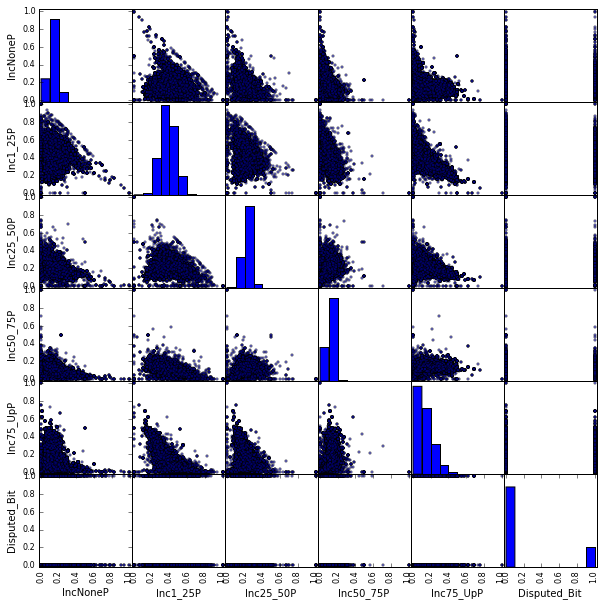

In [151]:
pd.scatter_matrix(Voltron[['IncNoneP','Inc1_25P','Inc25_50P','Inc50_75P','Inc75_UpP', 'Disputed_Bit']])

### Scatterplot Analaysis
As to be expected, the scatterplots show an inverse relationship between the income brackets.  There is also definitely a likelihood to not dispute, but it looks like it may sway in favor of the lower income brackets.

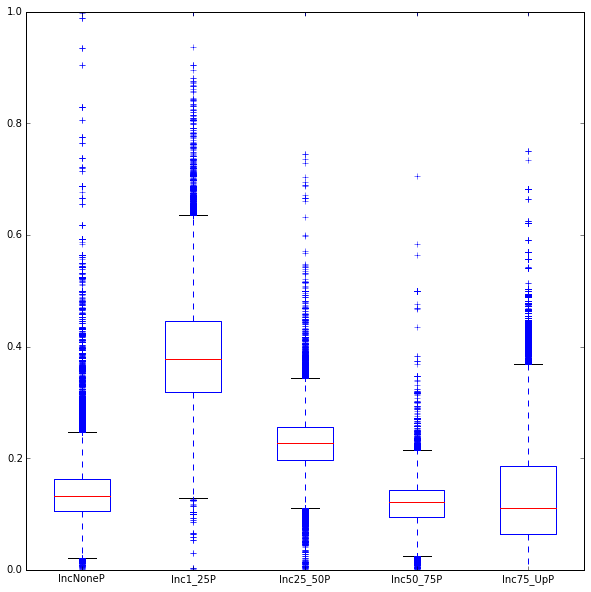

In [152]:
Voltron[['IncNoneP','Inc1_25P','Inc25_50P','Inc50_75P','Inc75_UpP']].plot(kind='box')


### Boxplot Analysis

As stated in the histogram analysis, the boxplots whos greater variances in their percentages.  Additionally, the No Income and \$50000-75000 incomes how low variances with a median rightly around 15%

# Linear Regression

I've decided to utilize linear regression so that we can interpret the the net effects of income brackets on the consumer's decisions to dispute the company's response.

In [168]:
# create X and y
feature_cols = ['IncNoneP','Inc1_25P','Inc25_50P','Inc50_75P','Inc75_UpP']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit

# import, instantiate, fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

14652888112.2
[ -1.46528881e+10  -1.46528881e+10  -1.46528881e+10  -1.46528881e+10
  -1.46528881e+10]


Given that the coefficients all turns out the same when I included all the percentages, I thought it might make sense to remove the bracket of No Income.  Perhaps this is because having all the percentages would always equal to 1?

In [170]:
feature_cols = ['Inc1_25P','Inc25_50P','Inc50_75P','Inc75_UpP']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit
linreg = LinearRegression()
linreg.fit(X, y)

print linreg.intercept_
print linreg.coef_

0.150540178252
[ 0.04229952  0.05174648 -0.01914956  0.20602198]


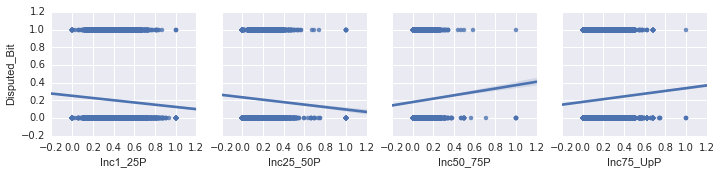

In [172]:
# multiple scatter plots with fit lines. Takes long to generate!!!
sns.pairplot(Voltron, x_vars=feature_cols, y_vars='Disputed_Bit', kind='reg')

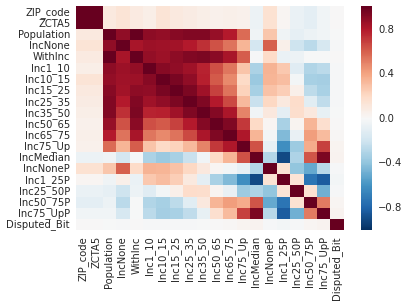

In [208]:
# heatmap
sns.heatmap(Voltron.corr())

The heatmaps shows that much of the Income data is highly correlated with eachother with the giant red block.  Only once the data becomes transformed to control for population, then it becomes a little more ambiguous.  The Strangely, the highest income bracket percentage is correlated with the median income.

## Conduct a Train-Test-Split to test the model

In [214]:
feature_cols = ['Inc1_25P','Inc25_50P','Inc50_75P','Inc75_UpP']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print 'MAE:', metrics.mean_absolute_error(y_test, y_pred)
print 'MSE:', metrics.mean_squared_error(y_test, y_pred)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))

 MAE: 0.32416511149
MSE: 0.162018428089
RMSE: 0.402515127777


In [217]:
# Compare with NULL
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)
y_null = np.zeros_like(y_test, dtype=float)
y_null.fill(y_test.mean())

print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_null))

RMSE: 0.402806493821


The model only does marginally better than the NULL model.  This is probably because for the most part, the predicted value will always be No Dispute.  While the trained model whas a slope and gives the possibility of a Dispute, even if it never gets over the 0.50 on the Y-axis.

# Logistic Regression (In Progress...for Comparison to Linear Regression)

In [220]:
# fit a logistic regression model and store the class predictions

logreg = LogisticRegression()
feature_cols = ['Inc1_25P','Inc25_50P','Inc50_75P','Inc75_UpP']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit
logreg.fit(X, y)
Voltron['PredictedDispute'] = logreg.predict(X)

In [226]:
Voltron['PredictedDispute_prob'] = logreg.predict_proba(X)[:, 1]

In [228]:
plt.scatter(Voltron.Inc1_25P, Voltron.Disputed_Bit)
plt.plot(Voltron.Inc1_25P, Voltron.PredictedDispute_prob, color='red')
plt.xlabel('Inc1_25P')
plt.ylabel('Disputed?')

OverflowError: Allocated too many blocks

# Challenges and Successes

The biggest challenge that I faced was figuring out a question that was meaningful that would be solvable using one of the modeling techniques shown in class.  While I understand that not all questions can be answered, or that the available data may not be of the highest quality, developing a question based on given data is another story.  Given that the biggest hurdle I faces was that I lack the Subject Matter Expertise, it was difficult to get a good question simply at a glance of the data.

As for successes.  This project has encouraged me to really dig through the datasaet and find out what each field really means.  Perhaps using the income brackets weren't the best features to use, but I really wanted to incorporate the income side of the data while controlling for variations in zipcode population.  The Median field seems to be a lot more reasonable.

# Possible extensions or business applications of your project

Given that this was originally a Skills Assessment test, I don't think there are any direct business applications.  However, there are many different fields that are available in the ACS relating to many different topics.  Income may not be the most interesting choice.  Furthermore, I think simply choosing fields within the Complaints data as features would have netted a better result, but part of the exercise was to be able to join the datasets and clean them.

# Conclusions and key learnings

For the most part, people generally don't dispute company responses to consumer complaints.  The motivation for them disputing hinges on far too many factors to simply assume that income bracket distribution of their zipcode would be a good indicator.  However, what I did find interesting were the overall distibutions of those brackets within the complaints.  Perhaps the project could have been less skewed if I had chosen to not assume that Non-reponses were the same as No Dispute.  Additionally, perhaps limiting the scope of the project to only a single state would probably have made the findings more applicable.